# Self Organized Maps (SOMs)

## Import Libraries

In [62]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

# MiniSOM
from minisom import MiniSom

# XPySOM
from xpysom import XPySom

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps
# from simpsom.plots import scatter_on_map

# Astropy
from astropy.table import Table

In [40]:
from psutil import *
# This code will return the number of CPU
print("Number of CPU: ", cpu_count())
# This code will return the CPU info
!cat /proc/cpuinfo

Number of CPU:  64
processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 8
model name	: AMD Ryzen Threadripper 2990WX 32-Core Processor
stepping	: 2
microcode	: 0x800820d
cpu MHz		: 2800.000
cache size	: 512 KB
physical id	: 0
siblings	: 64
core id		: 0
cpu cores	: 32
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid amd_dcm aperfmperf rapl pni pclmulqdq monitor ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand lahf_lm cmp_legacy svm extapic cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw skinit wdt tce topoext perfctr_core perfctr_nb bpext perfctr_llc mwaitx cpb hw_pstate ssbd ibpb vmmcall fsgsbase bmi1 avx2 smep bmi2 rdseed adx smap clflushopt sha_ni xsaveopt xsavec xgetbv1 xsaves clzero irperf xsaveerptr 

## Import catalog

In [41]:
emu_matched_catalog_path = '/data/mfonseca/cross_match/EMU_0102-32/EMU_0101-32_DES_VIKING_CATWISE/EMU_0102-32_DES_VIKING_CATWISE.fits'
emu_matched_catalog = Table.read(emu_matched_catalog_path)
emu_matched_catalog = emu_matched_catalog.to_pandas()

In [42]:
emu_matched_catalog.describe()

,EMU_n_components,EMU_ra_deg_cont,EMU_dec_deg_cont,EMU_freq,EMU_maj_axis,EMU_min_axis,EMU_pos_ang,EMU_flux_int,EMU_flux_int_err,EMU_flux_peak,...,bias_VKG_jPetroMag,bias_VKG_yPetroMag,bias_VKG_ksPetroMag,bias_VKG_hPetroMag,bias_CAT_w1mpro,bias_CAT_w2mpro,p_single,p_any,p_i,match_flag
count,244803.0,244803.000000,244803.000000,244803.0,244803.000000,244803.000000,244803.000000,244803.000000,244803.0,244803.000000,...,244803.000000,244803.000000,244803.000000,244803.000000,244803.000000,244803.000000,244803.000000,244803.000000,2.448030e+05,244803.000000
mean,1.0,15.490508,-32.388351,943.5,10.636465,8.797066,95.558945,1.507697,0.0,1.383931,...,1.279762,1.297439,1.251702,1.215204,1.970878,2.315025,0.732029,0.889013,7.338146e-02,0.120284
std,0.0,1.877682,1.318861,0.0,2.844254,1.843961,48.920898,18.256750,0.0,15.560542,...,1.200666,1.226873,1.170662,1.048316,1.749330,2.140046,0.411443,0.258944,2.231009e-01,0.386738
min,1.0,11.862466,-35.154328,943.5,5.860000,4.310000,0.000000,0.036000,0.0,0.122000,...,0.404938,0.077019,0.270735,0.199832,0.165488,0.158431,0.000000,0.000000,0.000000e+00,0.000000
25%,1.0,13.957141,-33.483869,943.5,8.910000,7.320000,54.939999,0.114000,0.0,0.215000,...,0.594158,0.597044,0.700703,0.711125,1.000000,1.000000,0.395740,0.985841,1.194336e-11,0.000000
50%,1.0,15.490846,-32.370755,943.5,10.310000,8.560000,100.580002,0.197000,0.0,0.297000,...,0.594158,0.597044,0.700703,0.711125,1.000000,1.000000,0.997548,0.999995,1.292177e-06,0.000000
75%,1.0,17.044631,-31.245348,943.5,11.710000,10.190000,136.320007,0.452000,0.0,0.526000,...,1.624339,1.539979,1.230134,1.235064,2.583757,3.652712,0.999997,1.000000,1.560830e-03,0.000000
max,1.0,19.021128,-29.955183,943.5,75.919998,47.730000,179.990005,1606.759033,0.0,1410.647949,...,4.832622,4.441969,5.385254,4.417378,6.838447,7.803085,1.000000,1.000000,1.000000e+00,2.000000


In [43]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (emu_matched_catalog['match_flag'] == 1) & (emu_matched_catalog['p_i'] >= 0.1) & (emu_matched_catalog['p_any'] >=0.84)

# Recomendadion from https://www.eso.org/rm/api/v1/public/releaseDescriptions/135, page 7
vikings_match = (emu_matched_catalog['VKG_zppErrBits']<255) & (emu_matched_catalog['VKG_yppErrBits']<255) & (emu_matched_catalog['VKG_ksErrBits']<255) & (emu_matched_catalog['VKG_jErrBits']<255) & (emu_matched_catalog['VKG_hErrBits']<255)

catalog_filtered = emu_matched_catalog[match_mask & vikings_match]
print(len(catalog_filtered))


# Filter the catalog to keep only the magnitude columns
magnitude_columns = ['DES_mag_auto_g_dered', 'DES_mag_auto_r_dered', 'DES_mag_auto_i_dered', 'DES_mag_auto_z_dered',
                       'VKG_zPetroMag', 'VKG_jPetroMag', 'VKG_yPetroMag', 'VKG_ksPetroMag', 'VKG_hPetroMag', 'CAT_w1mpro', 'CAT_w2mpro']
catalog_filtered_magnitude = catalog_filtered[magnitude_columns]

# Should be the same lenght as the filtered catalog
print(len(catalog_filtered_magnitude))



10948
10948


Define the topology of the SOM, follow indications from "Self-Organizing Maps and Their Applications to Data Analysis" R. Ponmalai, C. Kamath

In [44]:
# SOM topology (lattice size)

# Number of sources in our dataframe
inputdata_size = len(catalog_filtered_magnitude)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_std = catalog_filtered_magnitude.cov()
eigen_values = np.linalg.eigvals(cov_std.values)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes if 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

Dimension of the SOM:  523
Square SOM map size  23.0
SOM map size using eigenvalues:  40 x 12


In [45]:
# Definine the  subset of the catalog to use
data_fraction2use = 1
data = catalog_filtered_magnitude.sample(frac=data_fraction2use)

# Normalize the data
data.to_numpy()
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values 

In [63]:
help(sps.SOMNet)

Help on class SOMNet in module simpsom.network:

class SOMNet(builtins.object)
 |  SOMNet(net_height, net_width, data, load_file=None, metric='euclidean', metric_kwds={}, init='PCA', PBC=False, GPU=False, random_seed=None)
 |
 |  Kohonen SOM Network class.
 |
 |  Methods defined here:
 |
 |  __init__(self, net_height, net_width, data, load_file=None, metric='euclidean', metric_kwds={}, init='PCA', PBC=False, GPU=False, random_seed=None)
 |      Initialise the SOM network.
 |
 |      Args:
 |          net_height (int): Number of nodes along the first dimension.
 |          net_width (int): Numer of nodes along the second dimension.
 |          data (self.interface.num.array or list): N-dimensional dataset.
 |          load_file (str, optional): Name of file to load containing information
 |              to initialize the network weights.
 |          metric (string): distance metric for the identification of best matching
 |              units. Accepts metrics available in scikit-learn (

In [69]:
# List of avaliable metrics https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html

som = sps.SOMNet(
    som_x,
    som_y,
    data,
    load_file = None,
    metric= 'euclidean',
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = False,
    random_seed = 42
)

som.train(
    train_algo = 'batch', 
    epochs = 20 ,
    start_learning_rate = 0.5 ,
    early_stop = None ,
    early_stop_patience = 5 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

Periodic Boundary Conditions active.
The weights will be initialized randomly.
The map will be trained with the batch algorithm.
Training SOM... done!


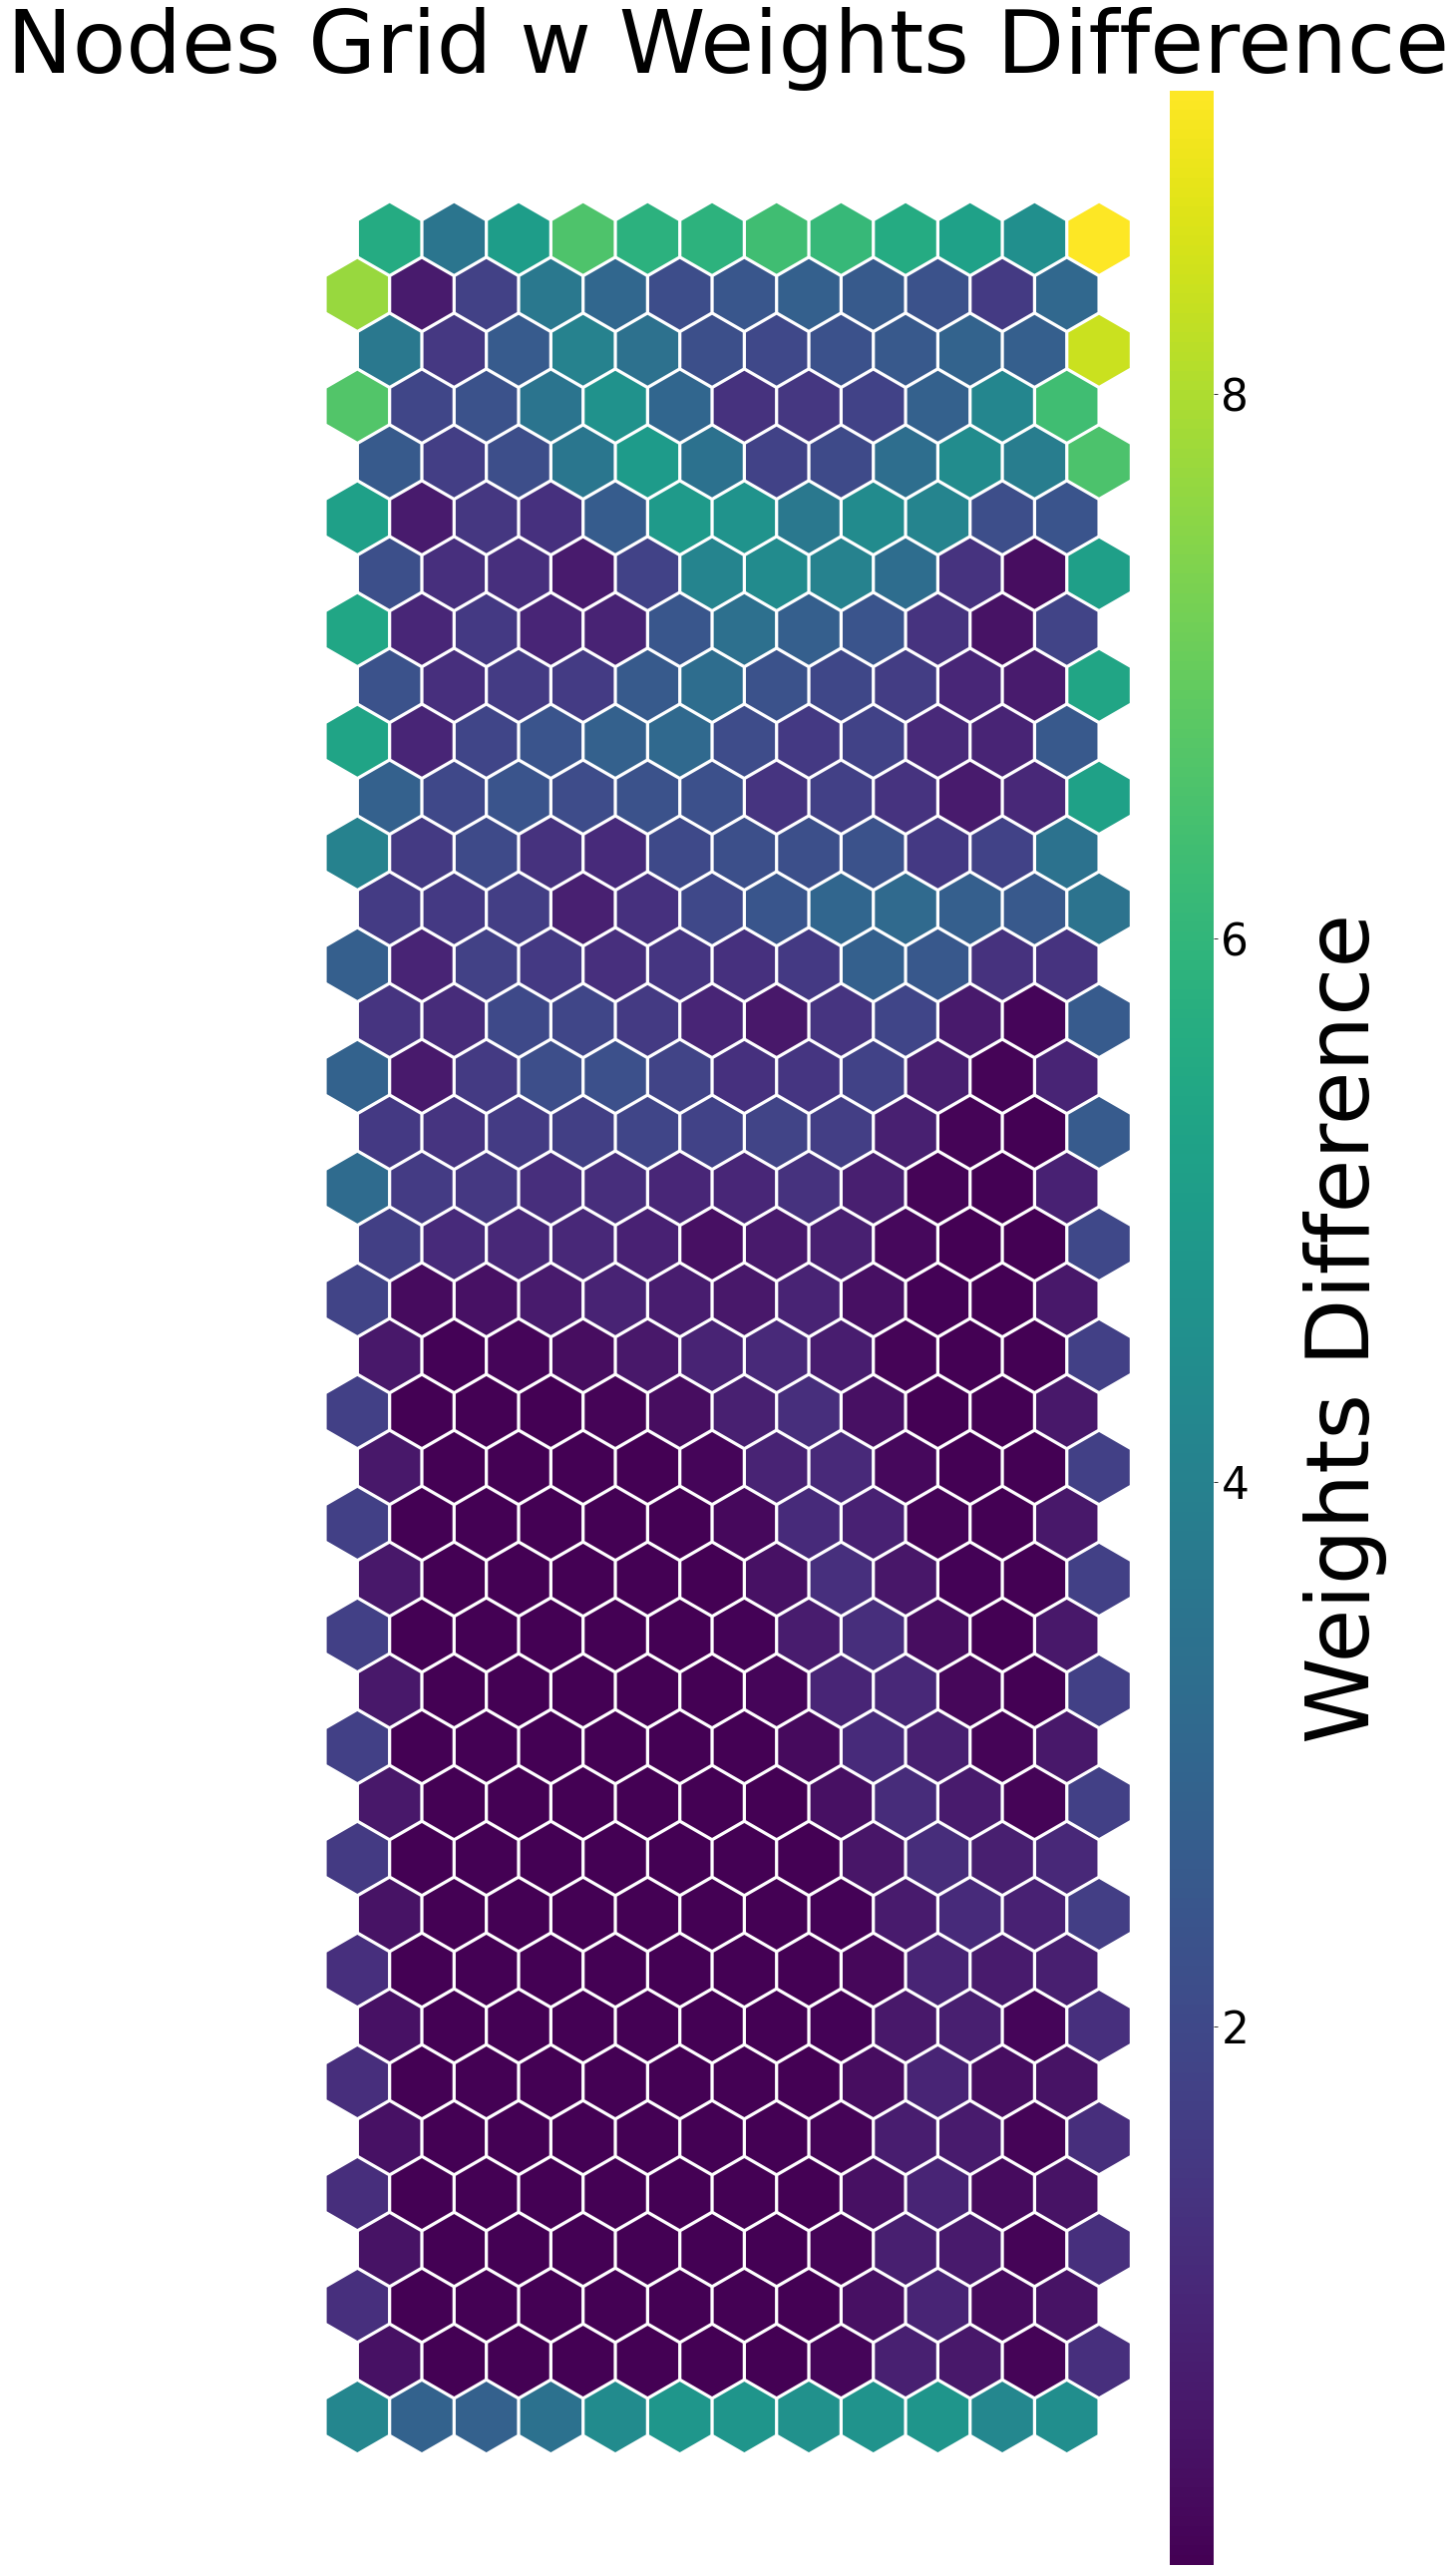

In [70]:
som.diff_graph(
    show = True ,
    print_out = False ,
    returns = False ,
    out_path = '/data/mfonseca/soms/EMU_0102-32/'
)

In [ ]:
clusters = som.cluster(data, clus_type='qthresh', show=True)
som.project(data, colnum=0, show=True)

### XPySom

In [ ]:
data_min = catalog_matrix.min(axis=0)
data_max = catalog_matrix.max(axis=0)
normalized_data = (catalog_matrix - data_min) / (data_max - data_min)

In [ ]:
galaxy_names = catalog_df['EMU_island_name'].values

# data normalization
data = (catalog_df_filtered - np.mean(catalog_df_filtered, axis=0)) / np.std(catalog_df_filtered, axis=0)
data = data.values

# Initialization and training
som_shape = (20, 20)
som = XPySom(20, 20, data)


## MiniSom

### Example

In [ ]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                    names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target'], usecols=[0, 5], 
                   sep='\t+', engine='python')
# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values


# Initialization and training
som_shape = (1, 3)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.5,
              neighborhood_function='gaussian', random_seed=10)

som.train_batch(data, 500, verbose=True)

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plotting centroids
for centroid in som.get_weights():
    plt.scatter(centroid[:, 0], centroid[:, 1], marker='x', 
                s=4, linewidths=10, color='k', label='centroid')
plt.legend(loc='best')

### With our galaxy values

In [ ]:
galaxy_names = catalog_df['EMU_island_name'].str.decode('utf-8').str.strip()

# Normalize the data
data = (catalog_df_filtered_matches_magnitude - np.mean(catalog_df_filtered_matches_magnitude, axis=0)) / np.std(catalog_df_filtered_matches_magnitude, axis=0)
data = data.values

In [ ]:
som_shape = (10, 10)
som = MiniSom(som_shape[0], som_shape[1], data.shape[1], sigma=.5, learning_rate=.1,
              neighborhood_function='gaussian', random_seed=0)

som.train_batch(data, 100000, verbose=True)

In [ ]:
plt.figure(figsize=(7, 7))
frequencies = som.activation_response(data)
plt.pcolor(frequencies.T, cmap='Blues') 
plt.colorbar()
plt.show()

In [ ]:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in data]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, som_shape)

In [ ]:
# plotting the clusters using the first 2 dimentions of the data
for c in np.unique(cluster_index):
    plt.scatter(data[cluster_index == c, 0],
                data[cluster_index == c, 1], label='cluster='+str(c), alpha=.7)

# plt.xlim(-.5,1)
# plt.ylim(-1,1)
